# **Save this file as studentid1_studentid2_lab#.ipynb**
(Your student-id is the number shown on your student card.)

E.g. Hence as an example for 2 students:
12301230_3434343_lab2.ipynb.

**This will be parsed by a regexp, so please double check your filename.**

**Only one member of each group has to submit the file to canvas.**

Before you turn this problem in, please make sure everything runs correctly. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). Note, that **you are not allowed to use Google Colab**.

**Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names and email adresses below.**



In [1]:
NAME = "Sander Bos"
NAME2 = "Rogier van Weerd"
EMAIL = "sander712@gmail.com"
EMAIL2 = ""


# Lab 2: Classification

### Machine Learning 1, September/October 2020

Notes on implementation:

* You should write your code and answers in this IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact your teaching assistant.
* Please write your answers right below the questions.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Use the provided test cells to check if your answers are correct
* **Make sure your output and plots are correct before handing in your assignment with Kernel -> Restart & Run All**

* **If possible, all your implementations should be vectorized and rely on loops as little as possible. Therefore for some questions, we give you a maximum number of loops that are necessary for an efficient implementation. This number refers to the loops in this particular function and does not count the ones in functions that are called from the function. You should not go above this number for the maximum number of points.**

$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\ba}{\mathbf{a}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bv}{\mathbf{v}}$
$\newcommand{\bq}{\mathbf{q}}$
$\newcommand{\bp}{\mathbf{p}}$
$\newcommand{\bh}{\mathbf{h}}$
$\newcommand{\bI}{\mathbf{I}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\bV}{\mathbf{V}}$

In [2]:
%pylab inline
plt.rcParams["figure.figsize"] = [9,5]

import time
start = time.time()

Populating the interactive namespace from numpy and matplotlib


In [3]:
# This cell makes sure that you have all the necessary libraries installed

import sys
import platform
from importlib.util import find_spec, module_from_spec

def check_newer_version(version_inst, version_nec):
    version_inst_split = version_inst.split('.')
    version_nec_split = version_nec.split('.')
    for i in range(min(len(version_inst_split), len(version_nec_split))):
        if int(version_nec_split[i]) > int(version_inst_split[i]):
            return False
        elif int(version_nec_split[i]) < int(version_inst_split[i]):
            return True
    return True
        
    
module_list = [('jupyter', '1.0.0'), 
               ('matplotlib', '2.0.2'), 
               ('numpy', '1.13.1'), 
               ('python', '3.6.2'), 
               ('sklearn', '0.19.0'), 
               ('scipy', '0.19.1'), 
               ('nb_conda', '2.2.1')]

packages_correct = True
packages_errors = []

for module_name, version in module_list:
    if module_name == 'scikit-learn':
        module_name = 'sklearn'
    if module_name == 'pyyaml':
        module_name = 'yaml'
    if 'python' in module_name:
        python_version = platform.python_version()
        if not check_newer_version(python_version, version):
            packages_correct = False
            error = f'Update {module_name} to version {version}. Current version is {python_version}.'
            packages_errors.append(error) 
            print(error)
    else:
        spec = find_spec(module_name)
        if spec is None:
            packages_correct = False
            error = f'Install {module_name} with version {version} or newer, it is required for this assignment!'
            packages_errors.append(error) 
            print(error)
        else:
            x =__import__(module_name)
            if hasattr(x, '__version__') and not check_newer_version(x.__version__, version):
                packages_correct = False
                error = f'Update {module_name} to version {version}. Current version is {x.__version__}.'
                packages_errors.append(error) 
                print(error)

try:
    from google.colab import drive
    packages_correct = False
    error = """Please, don't use google colab!
It will make it much more complicated for us to check your homework as it merges all the cells into one."""
    packages_errors.append(error) 
    print(error)
except:
    pass

packages_errors = '\n'.join(packages_errors)

# Part 1. Multiclass logistic regression

Scenario: you have a friend with one big problem: she's completely blind. You decided to help her: she has a special smartphone for blind people, and you are going to develop a mobile phone app that can do _machine vision_ using the mobile camera: converting a picture (from the camera) to the meaning of the image. You decide to start with an app that can read handwritten digits, i.e. convert an image of handwritten digits to text (e.g. it would enable her to read precious handwritten phone numbers).

A key building block for such an app would be a function `predict_digit(x)` that returns the digit class of an image patch $\bx$. Since hand-coding this function is highly non-trivial, you decide to solve this problem using machine learning, such that the internal parameters of this function are automatically learned using machine learning techniques.

The dataset you're going to use for this is the MNIST handwritten digits dataset (`http://yann.lecun.com/exdb/mnist/`). You can download the data with scikit learn, and load it as follows:

In [4]:
from sklearn.datasets import fetch_mldata
import os
# Fetch the data
try:
    mnist = fetch_mldata('MNIST original', data_home='.')
except Exception:
    raise FileNotFoundError('Please download mnist-original.mat from Canvas and put it in %s/mldata' % os.getcwd())
data, target = mnist.data, mnist.target.astype('int')
# Shuffle
indices = np.arange(len(data))
np.random.seed(123)
np.random.shuffle(indices)
data, target = data[indices].astype('float32'), target[indices]

# Normalize the data between 0.0 and 1.0:
data /= 255. 

# Split
x_train, x_valid, x_test = data[:50000], data[50000:60000], data[60000: 70000]
t_train, t_valid, t_test = target[:50000], target[50000:60000], target[60000: 70000]

/home/proteus/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)
/home/proteus/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)


MNIST consists of small 28 by 28 pixel images of written digits (0-9). We split the dataset into a training, validation and testing arrays. The variables `x_train`, `x_valid` and `x_test` are $N \times M$ matrices, where $N$ is the number of datapoints in the respective set, and $M = 28^2 = 784$ is the dimensionality of the data. The second set of variables `t_train`, `t_valid` and `t_test` contain the corresponding $N$-dimensional vector of integers, containing the true class labels.

Here's a visualisation of the first 8 digits of the trainingset:

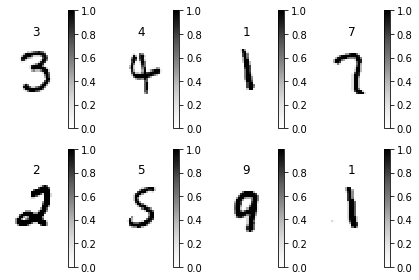

In [5]:
def plot_digits(data, num_cols, targets=None, shape=(28,28)):
    num_digits = data.shape[0]
    num_rows = int(num_digits/num_cols)
    for i in range(num_digits):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(data[i].reshape(shape), interpolation='none', cmap='Greys')
        if targets is not None:
            plt.title(int(targets[i]))
        plt.colorbar()
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_digits(x_train[0:40000:5000], num_cols=4, targets=t_train[0:40000:5000])

In _multiclass_ logistic regression, the conditional probability of class label $j$ given the image $\bx$ for some datapoint is given by:

$ \log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $\log q_j = \bw_j^T \bx + b_j$ (the log of the unnormalized probability of the class $j$), and $Z = \sum_k q_k$ is the normalizing factor. $\bw_j$ is the $j$-th column of $\bW$ (a matrix of size $784 \times 10$) corresponding to the class label, $b_j$ is the $j$-th element of $\bb$.

Given an input image, the multiclass logistic regression model first computes the intermediate vector $\log \bq$ (of size $10 \times 1$), using $\log q_j = \bw_j^T \bx + b_j$, containing the unnormalized log-probabilities per class. 

The unnormalized probabilities are then normalized by $Z$ such that $\sum_j p_j = \sum_j \exp(\log p_j) = 1$. This is done by $\log p_j = \log q_j - \log Z$ where $Z = \sum_i \exp(\log q_i)$. This is known as the _softmax_ transformation, and is also used as a last layer of many classifcation neural network models, to ensure that the output of the network is a normalized distribution, regardless of the values of second-to-last layer ($\log \bq$)

**Warning**: when computing $\log Z$, you are likely to encounter numerical problems. Save yourself countless hours of debugging and learn the [log-sum-exp trick](https://www.xarg.org/2016/06/the-log-sum-exp-trick-in-machine-learning/ "Title").

The network's output $\log \bp$ of size $10 \times 1$ then contains the conditional log-probabilities $\log p(t = j \;|\; \bx, \bb, \bW)$ for each digit class $j$. In summary, the computations are done in this order:

$\bx \rightarrow \log \bq \rightarrow Z \rightarrow \log \bp$

Given some dataset with $N$ independent, identically distributed datapoints, the log-likelihood is given by:

$ \mathcal{L}(\bb, \bW) = \sum_{n=1}^N \mathcal{L}^{(n)}$

where we use $\mathcal{L}^{(n)}$ to denote the partial log-likelihood evaluated over a single datapoint. It is important to see that the log-probability of the class label $t^{(n)}$ given the image, is given by the $t^{(n)}$-th element of the network's output $\log \bp$, denoted by $\log p_{t^{(n)}}$:

$\mathcal{L}^{(n)} = \log p(t = t^{(n)} \;|\; \bx = \bx^{(n)}, \bb, \bW) = \log p_{t^{(n)}} = \log q_{t^{(n)}} - \log Z^{(n)}$

where $\bx^{(n)}$ and $t^{(n)}$ are the input (image) and class label (integer) of the $n$-th datapoint, and $Z^{(n)}$ is the normalizing constant for the distribution over $t^{(n)}$.


## 1.1 Gradient-based stochastic optimization
### 1.1.1 Derive gradient equations (20 points)

Derive the equations for computing the (first) partial derivatives of the log-likelihood w.r.t. all the parameters, evaluated at a _single_ datapoint $n$.

You should start deriving the equations for $\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$ for each $j$. For clarity, we'll use the shorthand $\delta^q_j = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$.

For $j = t^{(n)}$:
$$
\delta^q_j
= \frac{\partial \log q_{t^{(n)}}}{\partial \log q_j}
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= 1
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
$$

For $j \neq t^{(n)}$:
$$
\delta^q_j
= \frac{\partial \log q_{t^{(n)}}}{\partial \log q_j}
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
=0 - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
$$

Complete the above derivations for $\delta^q_j$ by furtherly developing $\frac{\partial \log Z}{\partial Z}$ and $\frac{\partial Z}{\partial \log q_j}$. Both are quite simple. For these it doesn't matter whether $j = t^{(n)}$ or not.



For $j = t^{(n)}$:
\begin{align}
\delta^q_j
&= 1 - \frac{q_j}{\sum_i \exp [\log q_i]}
\end{align}
For $j \neq t^{(n)}$:
\begin{align}
\delta^q_j
&= 0 - \frac{q_j}{\sum_i \exp [\log q_i]}
\end{align}
YOUR ANSWER HERE

<span style="color:red">
We know that $\mathbf{Z} = \sum_i \exp [\log q_i]$, so the first term develops as follows:
    \begin{align*}
    \frac{\partial\log \mathbf{Z}}{\partial\mathbf{Z}} &= \frac{1}{Z}\\
    &= \frac{1}{\sum_i \exp [\log q_i]}
    \end{align*}
    
And for the second term:
\begin{align*}
    \frac{\partial\mathbf{Z}}{\partial \log q_j} &= \frac{\partial \sum_i \exp [\log q_i] }{\partial \log q_j}\\
    &= q_j
\end{align*}

Now, their product evaluates to:
\begin{align*}
    \frac{\partial\log \mathbf{Z}}{\partial\mathbf{Z}}\frac{\partial\mathbf{Z}}{\partial \log q_j} &= \frac{q_j}{\sum_i \exp [\log q_i]} 
\end{align*}
    
</span>

Given your equations for computing the gradients $\delta^q_j$ it should be quite straightforward to derive the equations for the gradients of the parameters of the model, $\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}}$ and $\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}$. The gradients for the biases $\bb$ are given by:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial b_j}
= \delta^q_j
\cdot 1
= \delta^q_j
$

The equation above gives the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element of $\bb$, so the vector $\nabla_\bb \mathcal{L}^{(n)}$ with all derivatives of $\mathcal{L}^{(n)}$ w.r.t. the bias parameters $\bb$ is: 

$
\nabla_\bb \mathcal{L}^{(n)} = \mathbf{\delta}^q
$

where $\mathbf{\delta}^q$ denotes the vector of size $10 \times 1$ with elements $\mathbf{\delta}_j^q$.

The (not fully developed) equation for computing the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element $W_{ij}$ of $\bW$ is:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
$

What is $\frac{\partial \log q_j}{\partial W_{ij}}$? Complete the equation above.

If you want, you can give the resulting equation in vector format ($\nabla_{\bw_j} \mathcal{L}^{(n)} = ...$), like we did for $\nabla_\bb \mathcal{L}^{(n)}$.

YOUR ANSWER HERE

<span style="color:red">
The asked expression denotes the gradient of the weight parameter. We know that $\log q_j = \bw_j^T \bx + b_j$ and the expression develops as follows:
    
$\frac{\partial\log q_j}{\partial\mathbf{W}_{ij}} = \frac{\partial\mathbf{W}_{j}^T\mathbf{x}+ b_j}{\partial\mathbf{W_{ij}}} = x_i$
    
This gives us the completed equation:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}} = \mathbf{\delta}_j^q x_i
$

In vector format we need to account for all $i$:

$\nabla_{\bw_j} \mathcal{L}^{(n)} = \mathbf{\delta}_j^q \mathbf{x}^T$
</span>

ANTWOORD ROGIER

<span style=color:blue>
$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
\\$
    
With:
    
$\frac{\partial \log q_j}{\partial W_{ij}} = 
\frac{\partial(w_j^Tx+b_j)}{\partial W_{ij}}=
\frac{\partial \sum\limits_{k=1}^{10}\big((w_j^T)_k x_k +b_j)\big)}{\partial W_{ij}}=
\frac{\partial \sum\limits_{k=1}^{10}\big((W_{kj} x_k +b_j)\big)}{\partial W_{ij}}= x_{i}$
    
So,
    
$\boxed{\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} = \delta_j^qx_i}$ (a scalar)
    
Or, following the convention used in the question:
    
$\boxed{\nabla_{w_j} \mathcal{L}^{(n)} = \delta_j^qx}$ (a (10x1) vector)
    
We can even write this in matrix form using the outer product:
    
$\boxed{\nabla_\bW \mathcal{L}^{(n)} = {\delta^{q}} \mathbf{x}^{T}}$ (a (10x784) matrix, this applies the ML1 convention on the shape of the gradient w.r.t a matrix)
</span>

### 1.1.2 Implement gradient computations (15 points)

Implement the gradient calculations you derived in the previous question. Write a function `logreg_gradient(x, t, w, b)` that returns the gradients $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (for each $j$) and $\nabla_{\bb} \mathcal{L}^{(n)}$, i.e. the first partial derivatives of the log-likelihood w.r.t. the parameters $\bW$ and $\bb$, evaluated at a single datapoint (`x`, `t`).
The computation will contain roughly the following intermediate variables:

$
\log \bq \rightarrow Z \rightarrow \log \bp\,,\, \mathbf{\delta}^q
$

followed by computation of the gradient vectors $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (contained in a $784 \times 10$ matrix) and $\nabla_{\bb} \mathcal{L}^{(n)}$ (a $10 \times 1$ vector).

For maximum points, ensure the function is numerically stable.


In [6]:
# 1.1.2 Compute gradient of log p(t|x;w,b) wrt w and b
def logreg_gradient(x, t, w, b):
    log_q = np.dot(x,w) + b # j-th element is log unnormalized probability of class j. logQ is a (1x10) vector

    #The following lines rely on the log-sum-exp trick.
    a = np.max(log_q)
    log_Z = a + np.log(np.sum(np.exp(log_q - a))) # normalizing factor (scalar)
    Z = np.exp(log_Z)
    logp = log_q - log_Z # softmax transformation (elementwise), logP is a (1x10) vector
    
    dL_db = - np.exp(log_q) / Z
    dL_db[:,t] = 1 + dL_db[:,t] # for j=t (follows our derivation of the partial derivative) 
#     dL_dw = np.outer(x,dL_db)

    dL_dw = np.dot(x[0].reshape(-1,1),dL_db)

    # here the statement contains logp[:,t] where logp is meant tas a matrix of shape 1x10

    return logp[:,t].squeeze(), dL_dw, dL_db.squeeze()


In [7]:
# Hidden tests for efficiency

In [8]:
np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

# test gradients, train on 1 sample
logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)

print("Test gradient on one point")
print("Log Likelihood:\t", logpt)
print("\nGrad_W_ij\t",grad_w.shape,"matrix")
print("Grad_W_ij[0,152:158]=\t", grad_w[152:158,0])
print("\nGrad_B_i shape\t",grad_b.shape,"vector")
print("Grad_B_i=\t", grad_b.T)
print("i in {0,...,9}; j in M")

assert logpt.shape == (), logpt.shape
assert grad_w.shape == (784, 10), grad_w.shape
assert grad_b.shape == (10,), grad_b.shape




Test gradient on one point
Log Likelihood:	 -2.2959726720744777

Grad_W_ij	 (784, 10) matrix
Grad_W_ij[0,152:158]=	 [-0.04518971 -0.06758809 -0.07819784 -0.09077237 -0.07584012 -0.06365855]

Grad_B_i shape	 (10,) vector
Grad_B_i=	 [-0.10020327 -0.09977827 -0.1003198   0.89933657 -0.10037941 -0.10072863
 -0.09982729 -0.09928672 -0.09949324 -0.09931994]
i in {0,...,9}; j in M


In [9]:
# It's always good to check your gradient implementations with finite difference checking:
# Scipy provides the check_grad function, which requires flat input variables.
# So we write two helper functions that provide the gradient and output with 'flat' weights:
from scipy.optimize import check_grad

np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

def func(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return logpt
def grad(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return grad_w.flatten()
finite_diff_error = check_grad(func, grad, w.flatten())
print('Finite difference error grad_w:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for w seems off'

def func(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return logpt
def grad(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return grad_b.flatten()
finite_diff_error = check_grad(func, grad, b)
print('Finite difference error grad_b:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for b seems off'



Finite difference error grad_w: 6.361294689297725e-07
Finite difference error grad_b: 5.235117486085727e-08


In [10]:
# DO NOT REMOVE THIS CELL!
# It contains hidden tests



### 1.1.3 Stochastic gradient descent (15 points)

Write a function `sgd_iter(x_train, t_train, w, b)` that performs one iteration of stochastic gradient descent (SGD), and returns the new weights. It should go through the trainingset once in randomized order, call `logreg_gradient(x, t, w, b)` for each datapoint to get the gradients, and update the parameters **using a small learning rate of `1e-4`**. Note that in this case we're maximizing the likelihood function, so we should actually performing gradient ___ascent___... For more information about SGD, see Bishop 5.2.4 or an online source (i.e. https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

In [11]:
def sgd_iter(x_train, t_train, W, b):
    '''
    From the wiki link:
    Note that in each iteration (also called update), only the gradient evaluated at a single point x_i instead of evaluating at the set of all samples.
    The key difference compared to standard (Batch) Gradient Descent is that only one piece of data from the dataset is used to calculate the step, and the piece of data is picked randomly at each step. 
    '''
    lr = 1e-4
    N = t_train.shape[0]

    logp_train = 0
#     logp_train_t = 0
    for i in range(N):
        random_idx = np.random.randint(0, N)
        logpt, grad_w, grad_b = logreg_gradient([x_train[random_idx,:]], t_train[random_idx], W, b)
        W = W + (lr * grad_w)
        b = b + (lr * grad_b)
        logp_train += logpt
    
    #Are we interested in logp_train for each (randomly chosen) data point or 
    #Logp_train evaluated on all data points after the parameters are learned per epoch?
#     for i in range(N):
#         logpt, grad_w, grad_b = logreg_gradient([x_train[i,:]], [t_train[i]], W, b)
#         logp_train_t += logpt
        
#     print(logp_train)
#     print(logp_train_t)

#     return logp_train_t, W, b
    return logp_train, W, b

In [12]:
# Hidden tests for efficiency

In [13]:
# Sanity check:
np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10)
    
logp_train, W, b = sgd_iter(x_train[:5], t_train[:5], w, b)




## 1.2. Train

### 1.2.1 Train (12 points)
Perform SGD on the training set. Plot (in one graph) the conditional log-probability of the training set and validation set after each iteration. (6 points)

Instead of running SGD for a fixed number of steps, run it until convergence. Think of a reasonable criterion for determining convergence. As a reference: choose a criterion such that the algorithm terminates in less than 15 iterations over the training set. (2 points)

Make sure your implementation (in particular, the output of the conditional log-probability of the training set and validation set) is independent of the size of the dataset. (2 points)

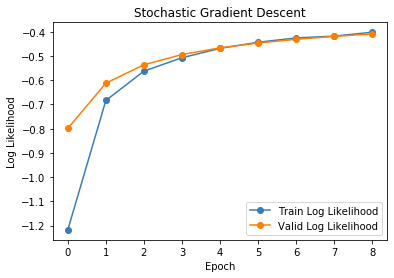

In [14]:
def test_sgd(x_train, t_train, x_valid, t_valid, w, b):
    #Initialize
    N_train = t_train.shape[0]; N_valid = x_valid.shape[0]
    train_logL= []; valid_logL = [np.inf]
    early_stopping_threshold = 1e-2
    previous_logp_valid = 0
    
    for epoch in range(15):
        logp_train = 0; logp_valid = 0

        #SGD iterations
        logp_train, w, b = sgd_iter(x_train, t_train, w, b)
        train_logL.append(logp_train /N_train)

        #Validate
        previous_logp_valid = valid_logL[-1]
        logp_valid = compute_logp(x_valid, t_valid, w, b)
        valid_logL.append(logp_valid/N_valid)
        
        #Stop early when the difference in current and previous valid error is smaller than some preset value
        if abs(valid_logL[-1] - previous_logp_valid) <= early_stopping_threshold:
            plot_logL(train_logL, valid_logL)
            return w, b
        
    #Plot the progress
    plot_logL(train_logL, valid_logL)
    
    return w, b 

def compute_logp(x_valid, t_valid, w, b):
    '''
    Computations as seen in logreg_gradient(x, t, w, b)
    '''
    logp_valid = 0
    for idx,x in enumerate(x_valid):
        log_q = np.dot([x],w) + b
        a = np.max(log_q)
        log_Z = a + np.log(np.sum(np.exp(log_q - a)))
        logp = log_q - log_Z

        logp_valid += logp[:,t_valid[idx]].squeeze()

    return logp_valid

def plot_logL(train_logL, valid_logL):
    #Colorblind color scheme
    plt.plot(np.arange(0,len(train_logL)), train_logL,'o-',color='#377eb8', label='Train Log Likelihood')
    plt.plot(np.arange(0,len(valid_logL) - 1), valid_logL[1:],'o-', color='#ff7f00', label='Valid Log Likelihood')
    plt.xlabel('Epoch')
    plt.ylabel('Log Likelihood')
    plt.title('Stochastic Gradient Descent')
    plt.legend(loc='lower right')

np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10)
w,b = test_sgd(x_train, t_train, x_valid, t_valid, w, b)

Epoch		 Improvement validation log L (%)
--------------------------------------------------------------------------------
1			inf
2			23.3840033944243
3			12.39423895765367
4			7.912333233320923
5			5.577956506765758
6			4.286778346189335
7			3.385000886803291
8			2.8377440378447805
9			2.3494327313290264
10			2.038584679836919
11			1.815575858590457
12			1.5454774852411202
13			1.4246975021468211


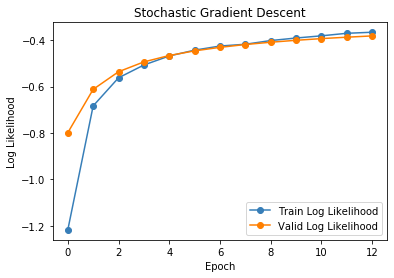

In [15]:
'''
SGD met Rogier's suggestie
'''

def test_sgd(x_train, t_train, x_valid, t_valid, w, b):
    '''
    Performs SGD for 100 epochs or untill a stopping criterion is satisfied.
    
    Stopping criterion:
    -----------------------
    Terminate when improvement of the log likelihood on the validation set drops below 1.5%
    '''
    #Initialize
    N_train = t_train.shape[0]; N_valid = x_valid.shape[0]
    train_logL= []; valid_logL = [np.inf]
    previous_logp_valid = 0
    
    #Improvement trackers
    start = True
    current = 0
    previous = 0
    improvement = 0
    THRESHOLD = 1.5 #Iterate untill improvement drops below THRESHOLD (in %)
    
    #Formatting output
    head = "Epoch\t\t Improvement validation log L (%)\n" + '-'*80
    fmt = "{epoch:s}\t\t\t{improvement:s}"
    print(head)
    
    for epoch in range(100):
        logp_train = 0; logp_valid = 0

        #SGD iterations
        logp_train, w, b = sgd_iter(x_train, t_train, w, b)
        train_logL.append(logp_train /N_train)

        #Validate
        previous_logp_valid = valid_logL[-1]
        logp_valid = compute_logp(x_valid, t_valid, w, b)
        valid_logL.append(logp_valid/N_valid)

        #Manage improvement trackers
        previous = current
        current = valid_logL[-1]
        if start:
            improvement = np.inf
            start = False
        else:
            improvement = - (current/previous -1)*100

#             print('log Likelihood improvement: {}'.format(improvement) + '%')      
        
        
        print(fmt.format(epoch=str(epoch+1), improvement=str(improvement)))  
        if improvement <= THRESHOLD:
            #Plot the progress
            plot_logL(train_logL, valid_logL)
            return w, b

    #Plot the progress
    plot_logL(train_logL, valid_logL)

    return w, b 

def compute_logp(x_valid, t_valid, w, b):
    '''
    Computations as seen in logreg_gradient(x, t, w, b)
    '''
    logp_valid = 0
    for idx,x in enumerate(x_valid):
        log_q = np.dot([x],w) + b
        a = np.max(log_q)
        log_Z = a + np.log(np.sum(np.exp(log_q - a)))
        logp = log_q - log_Z

        logp_valid += logp[:,t_valid[idx]].squeeze()

    return logp_valid

def plot_logL(train_logL, valid_logL):
    #Colorblind color scheme
    plt.plot(np.arange(0,len(train_logL)), train_logL,'o-',color='#377eb8', label='Train Log Likelihood')
    plt.plot(np.arange(0,len(valid_logL) - 1), valid_logL[1:],'o-', color='#ff7f00', label='Valid Log Likelihood')
    plt.xlabel('Epoch')
    plt.ylabel('Log Likelihood')
    plt.title('Stochastic Gradient Descent')
    plt.legend(loc='lower right')

np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10)
w,b = test_sgd(x_train, t_train, x_valid, t_valid, w, b)

In [16]:
# Hidden tests for efficiency

### 1.2.2 Visualize weights (10 points)
Visualize the resulting parameters $\bW$ after a few iterations through the training set, by treating each column of $\bW$ as an image. If you want, you can use or edit the `plot_digits(...)` above.


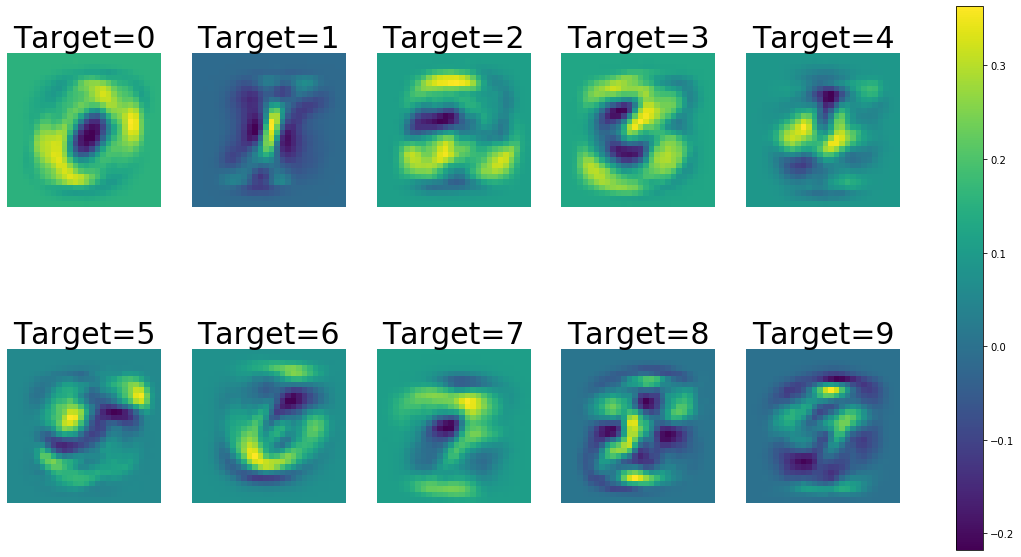

In [17]:
# YOUR CODE HERE
def visualize(w):
    '''
    Lets think about a color map, e.g.:
    seismic, gray, gray_r
    '''
    n_targets = w.shape[1]
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
    labels = ['Target={}'.format(t) for t in range(n_targets)]
    
    current_target = 0
    for row in range(2):
        for column in range(5):
            test = ax[row, column].imshow(w[:,current_target].reshape(28,28), label=labels[current_target])
            ax[row, column].set_title(labels[current_target], fontsize=30)
            ax[row, column].axis('off')
#             test.set_title(labels[current_target], fontsize=30)
#             test.axis('off')
            current_target += 1
            
    fig.colorbar(test, ax=ax)
visualize(w)

**Describe in less than 100 words why these weights minimize the loss**

<span style=color:red>
In the visualization for each weight vector w_j, we observe higher positive weights (yellow in color plot, dark in grayscale plot) for the areas that are associated with that particular digit, averaged over the dataset. In contrast, regions that are counter indicative of that digit have negative weights (blue / light). It is essentially a pattern matching mask. The class where the pattern matches best will yield the highest probability, leading to a low loss term when the correct class hotcode (1) is subtracted from that probability.
</span>

### 1.2.3. Visualize the 8 hardest and 8 easiest digits (10 points)
Visualize the 8 digits in the validation set with the highest probability of the true class label under the model.
Also plot the 8 digits that were assigned the lowest probability.


easiest logp on validation set
-7.762681841505525e-05 		prediction: 2
-5.529478083232675e-05 		prediction: 2
-5.455622367911417e-05 		prediction: 2
-5.2043916676680624e-05 		prediction: 2
-4.185153223623672e-05 		prediction: 2
-3.302605317756502e-05 		prediction: 2
-2.335779624829115e-05 		prediction: 2
-2.2671616065395028e-05 		prediction: 2
hardest logp on validation set
-13.690540286592928 		prediction: 0
-9.563160209862918 		prediction: 8
-8.252496290518405 		prediction: 3
-7.679322876333467 		prediction: 7
-7.350517093089393 		prediction: 2
-7.237799745030415 		prediction: 5
-6.987558832310913 		prediction: 7
-6.702926269520606 		prediction: 0


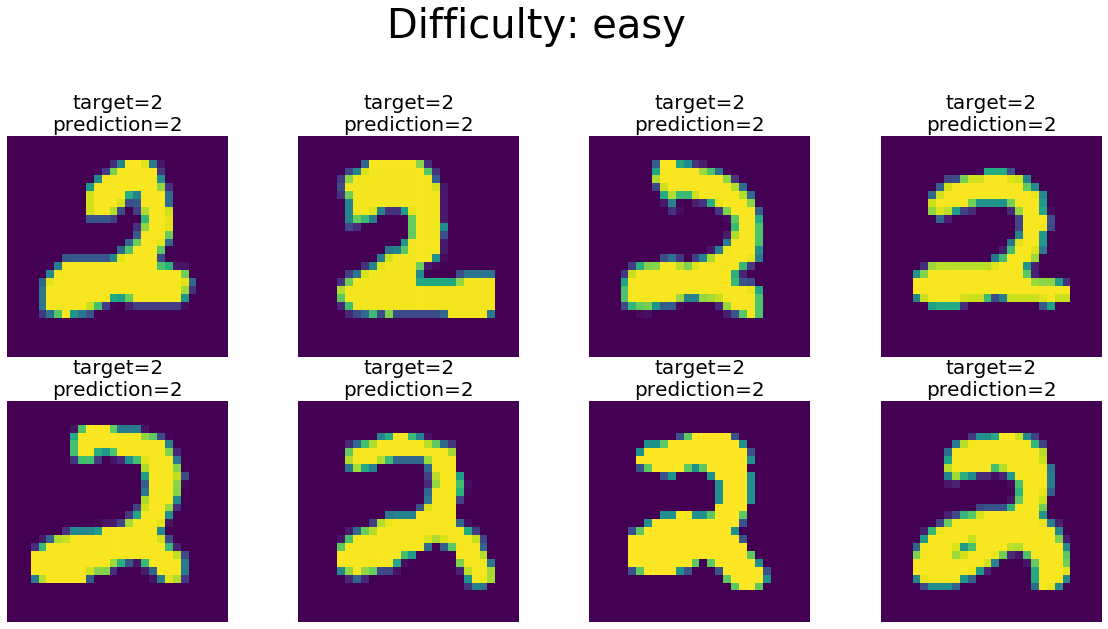

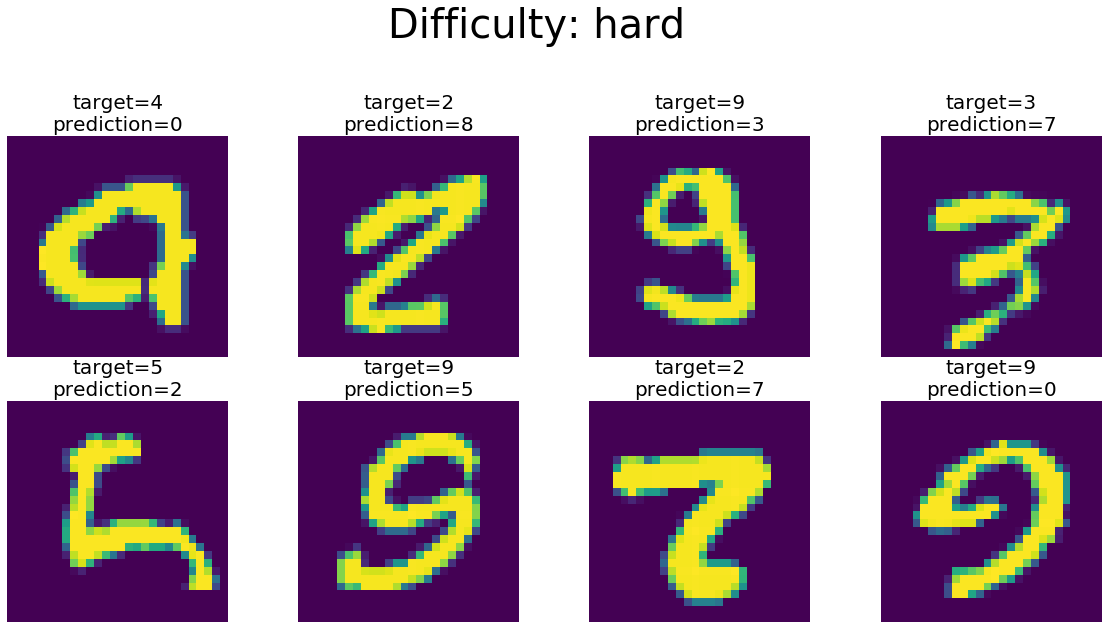

In [18]:
# YOUR CODE HERE
def logp_difficulty(x_valid, t_valid, w, b, difficulty):
    '''
    Computations as seen in logreg_gradient(x, t, w, b).
    
    '''
    logp_valid = []
    predictions = []
    for idx,x in enumerate(x_valid):
        log_q = np.dot([x],w) + b
        a = np.max(log_q)
        log_Z = a + np.log(np.sum(np.exp(log_q - a)))
        logp = log_q - log_Z
        logp_valid.append(logp[:,t_valid[idx]].squeeze())
        #We return the actual predictions
        predictions.append(logp.squeeze())
        
    #Sort low to high
    sorted_indices = np.argsort(logp_valid)
    if difficulty == 'hard':
        hardest = sorted_indices[:8]
        print('hardest logp on validation set')
        for i in hardest:
            prediction = np.argmax(predictions[i])
            print(logp_valid[i], '\t\tprediction:', prediction)
        return hardest, predictions

    elif difficulty == 'easy':
        easiest = sorted_indices[-8:]
        print('easiest logp on validation set')
        for i in easiest:
            prediction = np.argmax(predictions[i])
            print(logp_valid[i], '\t\tprediction:', prediction)
        return easiest, predictions

def visualize_difficulty(x, t, w, b, difficulties=['easy', 'hard']):
    for difficulty in difficulties:
        fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
        fig.suptitle('Difficulty: {}'.format(difficulty), fontsize=40)
        fig.subplots_adjust(top=0.8)
        logp_indices, predictions = logp_difficulty(x, t, w, b, difficulty)

        i = 0
        for row in range(2):
            for column in range(4):
                ax[row, column].imshow(x_valid[logp_indices[i],:].reshape(28,28))
                prediction = np.argmax(predictions[logp_indices[i]])
                ax[row, column].set_title('target='+str(t_valid[logp_indices[i]])+
                                          '\nprediction='+str(prediction), fontsize=20)
                ax[row, column].axis('off')
                i += 1
        
        

visualize_difficulty(x_valid, t_valid, w, b)


Ask yourself if these results make sense. Explain in no more then two sentences what it means that a digit is hard to classify.

<span style=color:red>
A digit is hard to clasify if its footprint deviates from the learned average pattern as characterized by the weight vectors seen above. This can be seen when digits are rotated, or when the handwriting is peculiar (thicker, thinner, with swipe, etc.) or deviates from the general learned pattern for the digit.
</span>

# Part 2. Multilayer perceptron


You discover that the predictions by the logistic regression classifier are not good enough for your application: the model is too simple. You want to increase the accuracy of your predictions by using a better model. For this purpose, you're going to use a multilayer perceptron (MLP), a simple kind of neural network. The perceptron will have a single hidden layer $\bh$ with $L$ elements. The parameters of the model are $\bV$ (connections between input $\bx$ and hidden layer $\bh$), $\ba$ (the biases/intercepts of $\bh$), $\bW$ (connections between $\bh$ and $\log q$) and $\bb$ (the biases/intercepts of $\log q$).

The conditional probability of the class label $j$ is given by:

$\log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $q_j$ are again the unnormalized probabilities per class, and $Z = \sum_j q_j$ is again the probability normalizing factor. Each $q_j$ is computed using:

$\log q_j = \bw_j^T \bh + b_j$

where $\bh$ is a $L \times 1$ vector with the hidden layer activations (of a hidden layer with size $L$), and $\bw_j$ is the $j$-th column of $\bW$ (a $L \times 10$ matrix). Each element of the hidden layer is computed from the input vector $\bx$ using:

$h_j = \sigma(\bv_j^T \bx + a_j)$

where $\bv_j$ is the $j$-th column of $\bV$ (a $784 \times L$ matrix), $a_j$ is the $j$-th element of $\ba$, and $\sigma(.)$ is the so-called sigmoid activation function, defined by:

$\sigma(x) = \frac{1}{1 + \exp(-x)}$

Note that this model is almost equal to the multiclass logistic regression model, but with an extra 'hidden layer' $\bh$. The activations of this hidden layer can be viewed as features computed from the input, where the feature transformation ($\bV$ and $\ba$) is learned.

## 2.1 Derive gradient equations (20 points)

State (shortly) why $\nabla_{\bb} \mathcal{L}^{(n)}$ is equal to the earlier (multiclass logistic regression) case, and why $\nabla_{\bw_j} \mathcal{L}^{(n)}$ is almost equal to the earlier case.

Like in multiclass logistic regression, you should use intermediate variables $\mathbf{\delta}_j^q$. In addition, you should use intermediate variables $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial h_j}$.

Given an input image, roughly the following intermediate variables should be computed:

$
\log \bq \rightarrow Z \rightarrow \log \bp \rightarrow \mathbf{\delta}^q \rightarrow \mathbf{\delta}^h
$

where $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial \bh_j}$.

Give the equations for computing $\mathbf{\delta}^h$, and for computing the derivatives of $\mathcal{L}^{(n)}$ w.r.t. $\bW$, $\bb$, $\bV$ and $\ba$. 

You can use the convenient fact that $\frac{\partial}{\partial x} \sigma(x) = \sigma(x) (1 - \sigma(x))$.

YOUR ANSWER HERE

<span style="color:red">
We are going to show that $\nabla_{\bb} \mathcal{L}^{(n)}$ is equal to the multiclass logistic regression case. 
    
Recall that the multiclass logistic regression form was given by:
\begin{equation}
\frac{\partial \mathcal{L}^{(n)}}{\partial b_j} = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j} \frac{\partial \log q_j}{\partial b_j} = \delta^q_j \cdot 1 = \delta^q_j
\end{equation}

And in vector form this was: 

$
\nabla_\bb \mathcal{L}^{(n)} = \mathbf{\delta}^q
$

We recognize that in the present case we have:
\begin{equation}\log q_j = \bw_j^T \bh + b_j\end{equation}

Therefore $\nabla_{\bb} \mathcal{L}^{(n)}$ is given by the following:
\begin{align*}
\frac{\partial \mathcal{L}^{(n)}}{\partial b_j} &= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j} \frac{\partial \log q_j}{\partial b_j} \\
&= \delta^q_j \cdot \frac{\partial\bw_j^T \bh + b_j}{\partial b_j}\\
&= \delta^q_j \cdot \bigg(\frac{\partial\bw_j^T \bh}{\partial b_j} + \frac{\partial b_j}{\partial b_j}\bigg)\\
&= \delta^q_j \cdot (0+1) \\
&= \delta^q_j
\end{align*}

Similar to before, the foregoing shows the derivative w.r.t. a single element of $\bb$, so the vector $\nabla_\bb \mathcal{L}^{(n)}$ with all derivatives of $\mathcal{L}^{(n)}$ w.r.t. the bias parameters $\bb$ is: 

$
\nabla_\bb \mathcal{L}^{(n)} = \mathbf{\delta}^q
$

Which is equivalent to the multiclass logistic regression case.

---------------------------------------------------------

Now we are going to show that $\nabla_{\bw_j} \mathcal{L}^{(n)}$ is almost equal to the multiclass logistic regression case, which was given by $\delta^{q} \mathbf{x}^{T}$. 

First, we have to realize that the output of the network does not directly depend on the data vector $\bx$, but the output of the hidden layer $\bh$ instead. Therefore it is reasonable to assume that this is where the difference shows up. We will now show that this is indeed the case:

\begin{align*}
\frac{\partial \mathcal{L}^{(n)}}{\partial \bW_j} &= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}\frac{\partial \log q_j}{\partial \bW_{j}}\\
&= \delta^q_j \bigg( \frac{\partial \bW_{j}^T\bh}{\partial \bW_j} + \frac{\partial \bb_j}{\partial \bh}\bigg)\\
&= \delta^q_j (\bh + 0)\\
&= \delta^q_j \bh
\end{align*}

Again, this is the derivative w.r.t. a single element, so in vector form we have: $\nabla_{\bw} \mathcal{L}^{(n)} = \mathbf{\delta}^q \bh^T$. Just as predicted, the only difference is the vector $\bh$ instead of $\bx$.

---------------------------------------------------------
We derive the intermediate variable $\mathbf{\delta}_j^h$.

\begin{align*}
\frac{\partial \mathcal{L}^{(n)}}{\partial \bh_j} &= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}\frac{\partial \log q_j}{\partial \bh_{j}}\\
&= \mathbf{\delta}^q_j \bigg( \frac{\partial \bW_{j}^T\bh_j}{\partial \bh_j} + \frac{\partial \bb_j}{\partial \bh_j}\bigg)\\
&= \delta^q_j (\bW_j + 0)\\
&= \delta^q_j \bW_j
\end{align*} 

In vector form this is: $\mathbf{\delta}^h = \mathbf{\delta}^q \bW^T$

---------------------------------------------------------
Now we are going to show the derivation for $\nabla_{\bv} \mathcal{L}^{(n)}$ using some of the foregoing equations. Recall the following:

$\textbf{(1)}\hspace{1cm}\delta_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}\frac{\partial \log q_j}{\partial \bh_{j}} \hspace{3cm}\textbf{(2)}\hspace{1cm} h_j = \sigma(\bv_j^T \bx + a_j)$

This allows us to make the following derivation:

\begin{align*}
\frac{\partial \mathcal{L}^{(n)}}{\partial \bV_j} &= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}\frac{\partial \log q_j}{\partial h_{j}} \frac{\partial h_{j}}{\partial (v_{j}^T\bx + a_j)}\frac{\partial (v_{j}^T\bx + a_j)}{\partial \bV_j}
\end{align*}

We substitute $\textbf{(1)}$ into the above:

\begin{align*}
&= \delta_j^h \frac{\partial h_{j}}{\partial (v_{j}^T\bx + a_j)}\frac{\partial (v_{j}^T\bx + a_j)}{\partial \bV_j}
\end{align*}

We use the convenient fact that: $\frac{\partial}{\partial x} \sigma(x) = \sigma(x) (1 - \sigma(x))$.

\begin{align*}
&= \delta_j^h h_j (1 - h_j)\frac{\partial (v_{j}^T\bx + a_j)}{\partial \bV_j}\\
&= \delta_j^h h_j (1 - h_j) x_i
\end{align*}

We have shown that $\nabla_{\bv_j} \mathcal{L}^{(n)} = \delta_j^h h_j (1 - h_j) x_i$. However, we can write this in vector form using the outer product:

---------------------------------------------------------
Lastly, we compute $\nabla_\ba \mathcal{L}^{(n)}$ using the previous derivations:

\begin{align*}
\frac{\partial \mathcal{L}^{(n)}}{\partial a_j} &= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}\frac{\partial \log q_j}{\partial h_{j}} \frac{\partial h_{j}}{\partial (v_{j}^T\bx + a_j)}\frac{\partial (v_{j}^T\bx + a_j)}{\partial a_j}\\
&= \delta_j^h h_j (1 - h_j) \frac{\partial (v_{j}^T\bx + a_j)}{\partial a_j}\\
&= \delta_j^h h_j (1 - h_j) \cdot 1\\
&= \delta_j^h h_j (1 - h_j)
\end{align*}

In vector form this is given by the following:
</span>

## 2.2 MAP optimization (10 points)

You derived equations for finding the _maximum likelihood_ solution of the parameters. Explain, in a few sentences, how you could extend this approach so that it optimizes towards a _maximum a posteriori_ (MAP) solution of the parameters, with a Gaussian prior on the parameters. 

YOUR ANSWER HERE

## 2.3. Implement and train a MLP (15 points)

Implement an MLP model with a single hidden layer of **20 neurons**. 
Train the model for **10 epochs**.
Test your implementation for learning rates of 1e-2, 1e-3 and 1e-4 and plot (in one graph) the conditional log-probability of the trainingset and validation set. 

For the best model plot the weights of the first layer for in epoch 0,4 and 9. 


- 10 points: Working MLP that learns with plots
- +5 points: Fast, numerically stable, vectorized implementation

In [232]:
def sigmoid(x):
    '''
    Activation function
    '''
    return 1 / (1 + np.exp(-x)) 

def propagate(x,t, w, b, v, a):
    '''
    Performs a forward pass of a single data point and keeps
    track of the gradients.
    
    Input shapes:
    -----------------------
    x = (784x1)
    t = scalar
    v = (784x20)
    a = (20x1)
    w = (20x10)
    b = (10x1)
    '''
    #Forward pass
    h = sigmoid(np.dot(v.T, x) + a) #(20x1)
    logq = np.dot(w.T, h) + b       #(10x1)
    
    #-----------------=== Track gradients ===-----------------
    #log-sum-exp trick
    Z0 = np.max(logq)
    logZ = Z0 + np.log(np.sum(np.exp(logq - Z0)))
    Z=np.exp(logZ)
    logp=logq-logZ                  #(10x1)
    
    delta_q = - np.exp(logq) / Z
    delta_q[t] += 1                 #(10x1)
    #Hmm klopt dit volgende?
    delta_h = np.dot(w, delta_q)    #(20x1)
    
    #Compute the gradients
    dL_db = delta_q
    dL_dw = np.dot(h, delta_q.T)    #(20x10)
    dL_da = delta_h * h * (1-h)     #(20x1)
    dL_dv = np.dot(x, dL_da.T)      #(784x20)

    return logp[t].squeeze(), dL_dw, dL_db, dL_dv, dL_da
    

def mlp_iter(x, t, w, b, v, a, lr):
    '''
    For N iterations selects a data point to propagate forward. 
    Passes the data point to the propagate function from which it 
    receives logp and the gradients. Then it performs a backward 
    pass.
    '''
    logp_total = 0
    N = t.shape[0]
    for i in range(N):
        #Randomly select a data point index
        random_idx = np.random.randint(0, N)
        
        #Propagate forward
        logp, dL_dw, dL_db, dL_dv, dL_da = propagate(x[random_idx].reshape(-1,1), t[random_idx], w, b, v, a)
        
        #Backward pass
        w = w + lr * dL_dw
        b = b + lr * dL_db
        v = v + lr * dL_dv
        a = a + lr * dL_da
        
        logp_total += logp
        
#         raise ValueError
        
    return logp_total, w, b, v, a

In [233]:
# Hidden tests for efficiency

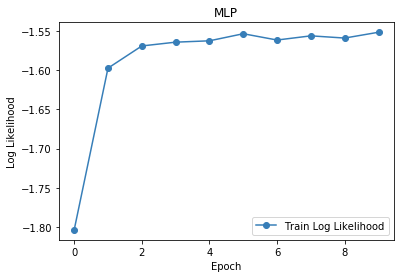

In [237]:
def train(x_train, t_train, x_valid, t_valid, w, b, v, a, learning_rates):
    N_train = t_train.shape[0]; N_valid = x_valid.shape[0]
    
    #Repeat training procedure for different learning rates
    for lr in learning_rates:
        train_logL= []; valid_logL = [np.inf]
        
        #-----------------=== Learning Procedure ===-----------------
        for epoch in range(10):
            #Training
            logp_total, w, b, v, a = mlp_iter(x_train, t_train, w, b, v, a, lr)
            train_logL.append(logp_total /N_train)
            
            #Validation
            
            #Early stopping
            
        #Plotting
        plot_mlp(train_logL)
        
        return w, b, v, a
        
        
input_size = 28*28
hidden_size = 20
output_size = 10
np.random.seed(1243)
v = np.zeros((input_size, hidden_size))
w = np.zeros((hidden_size, output_size))
a = np.zeros((hidden_size, 1))
b = np.zeros((output_size, 1))
learning_rates = [1e-2, 1e-3, 1e-4]
w, b, v, a = train(x_train, t_train, x_valid, t_valid, w, b, v, a, learning_rates)

In [ ]:
# # Write training code here:
# # Plot the conditional loglikelihoods for the train and validation dataset after every iteration.
# # Plot the weights of the first layer.

# def train(x_train, t_train, x_valid, t_valid, v, w, a ,b, learning_rates):
#     N_train = t_train.shape[0]; N_valid = x_valid.shape[0]
#     train_logL= []; valid_logL = [np.inf]
#     test = [1]
#     for lr in test: #learning_rates:
#         for epoch in range(10):
#             logp_train = 0; logp_valid = 0
#             #Propagate forward
#             for n in range(N_train):
#                 x, t = random_datapoint(x_train, t_train)
#                 h, logpt, log_q, Z, log_Z, logp = forward_pass(x,t,v,a,w,b)
#                 logp_train += logpt
#             train_logL.append(logp_train/N_train)
                
#             #Propagate backward
#             w, b, v, a = backward_pass(x, h, t, w, b, v, a, log_q, Z, log_Z, logp,lr)
            
#     #Plot the progress
#     plt.plot(np.arange(0,len(train_logL)), train_logL, 'o-')  
#     return w, b, v, a

# input_size = 28*28
# hidden_size = 20
# output_size = 10
# np.random.seed(1243)
# v = np.zeros((input_size, hidden_size))
# w = np.zeros((hidden_size, output_size))
# a = np.zeros(hidden_size)
# b = np.zeros(output_size)
# learning_rates = [1e-2, 1e-3, 1e-4]
# w, b, v, a = train(x_train, t_train, x_valid, t_valid, v, w, a ,b, learning_rates)

In [231]:
# plot the train and validation logp for all three learning rates in one figure

def plot_mlp(train_logL):
    #Colorblind color scheme
    plt.plot(np.arange(0,len(train_logL)), train_logL,'o-',color='#377eb8', label='Train Log Likelihood')
#     plt.plot(np.arange(0,len(valid_logL) - 1), valid_logL[1:],'o-', color='#ff7f00', label='Valid Log Likelihood')
    plt.xlabel('Epoch')
    plt.ylabel('Log Likelihood')
    plt.title('MLP')
    plt.legend(loc='lower right')
    

### 2.3.1. Explain the learning curves (5 points)
In less than 80 words, explain the observed behaviour for the different learning rates.

YOUR ANSWER HERE

### 2.3.2. Explain the weights (5 points)
In less than 80 words, explain how and why the weights of the hidden layer of the MLP differ from the logistic regression model, and relate this to the stronger performance of the MLP.

In [ ]:
# Plot the weights of the first layer for the best model 

# YOUR CODE HERE
raise NotImplementedError()

YOUR ANSWER HERE

### 2.3.2. Different activation functions (10 points)
In the task above we use a sigmoid as an activation function.
Two other popular choices for activation functions are tanh and the rectified linear unit (ReLU). The ReLU is defined as:

$$f(x) = \max(0.,x)$$

You already derived the derivative of the softmax function above. Here, write down the derivative for both the tanh and the ReLU function. Furthermore, for all three, plot the function and its derivative in a range $x\in[-3,3]$

Write down the derivative of ReLU and tanh w.r.t. their respective argument:

YOUR ANSWER HERE

Name two properties that you would like your activation function to have (one sentence each). Why are they important?

YOUR ANSWER HERE


In [ ]:
# plot the function and the derivative for the activations sigmoid, tanh and ReLU.

# YOUR CODE HERE
raise NotImplementedError()

Now that you plotted the activations and derivatives, which activation do you think is the best? Why would you choose this activation function? For your answer consider what you named as essential properties for an activation function above. Keep your answer short at no more then 3 sentences.

YOUR ANSWER HERE

In [ ]:
print('Notebook ran in {:2.3} minutes.'.format((time.time()-start)/60))